Install a few libraries

In [2]:
! pip install torch torchvision matplotlib numpy scikit-image torchinfo

Import packages

In [3]:
import random
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import skimage.io as io
from pathlib import Path
import sys

Utility functions

In [4]:
# Plot the time-series of errors and accuracies
# for validation and train splits
def plot_error_and_accuracy(errors, accuracies, title=""):
    """
    Args:
        errors (dict): dictionary of errors over epochs {"train": [], "val": []}
        accuracies (dict): similar, for accuracy
        title (optional, str): Plot title. Defaults to "".
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    x = range(len(errors["train"]))
    ax1.plot(x, errors["train"], label="Training")
    ax1.plot(x, errors["val"], label="Validation")
    ax1.title.set_text("Cross-entropy error")

    ax2.plot(x, accuracies["train"], label="Training")
    ax2.plot(x, accuracies["val"], label="Validation")
    ax2.title.set_text("Prediction Accuracy")

    if title:
        plt.suptitle(title)
    plt.legend()
    plt.show()

In [5]:
# GPUMonitor class to monitor GPU utilization in the background

import subprocess
import shutil
import os


def gpu_util():
    format = "csv,nounits,noheader"
    queries = ["utilization.gpu", "memory.used", "memory.free", "utilization.memory"]
    gpu_query = ",".join(queries)
    gpu_ids = 0

    result = subprocess.run(
        [
            shutil.which("nvidia-smi"),
            f"--query-gpu={gpu_query}",
            f"--format={format}",
            f"--id={gpu_ids}",
        ],
        encoding="utf-8",
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        check=True,
    )
    stats = [
        [float(x) for x in s.split(", ")]
        for s in result.stdout.strip().split(os.linesep)
    ][0]
    utilization = {}
    for k, q in enumerate(queries):
        utilization[q] = stats[k]
    return utilization


from threading import Thread
from time import sleep, time


class GPUMonitor:
    def __init__(self, timeout=1):
        self.timeout = timeout

        self._thread = Thread(target=self._monitor, daemon=True)
        self.utilization = None
        self.done = False
        self.start_time = self.stop_time = None

    def start(self):
        self._thread.start()
        self.start_time = time()
        return self

    def _monitor(self):
        while True:
            if self.done:
                break
            utilization = gpu_util()
            if self.utilization is None:
                self.utilization = {k: [] for k in utilization}
            for k, v in utilization.items():
                self.utilization[k].append(v)
            sleep(self.timeout)

    def __enter__(self):
        self.start()

    def stop(self):
        self.stop_time = time()
        self.done = True

    def __exit__(self, exc_type, exc_value, tb):
        # handle exceptions with those variables ^
        self.stop()

    def plot_all(self, figsize=(10, 10)):
        f, axs = plt.subplots(2, 2, figsize=figsize)
        for i in range(2):
            for j in range(2):
                ax = axs[i][j]
                k = list(self.utilization.keys())[i * 2 + j]
                data = self.utilization[k]
                ax.plot(range(len(data)), data)
                ax.title.set_text(k)
        plt.suptitle("GPU monitoring")

    def plot(self, k):
        assert k in self.utilization, f"Unknown metric {k}"
        data = self.utilization[k]
        plt.plot(range(len(data)), data)
        plt.title("GPU monitoring: " + k)

In [6]:
def correct(predictions, labels):
    """
    Counts the number of correct predictions

    Args:
        predictions (torch.Tensor): array of model predictions. Can be either
            1D (batch of class indices) or 2D (batch of prediction vectors)
        labels (torch.Tensor): array of ground truth target labels (1D)
    """
    if predictions.ndim > labels.ndim:
        predictions = predictions.max(1).indices

    correct_predictions = predictions.cpu() == labels.cpu()
    correct_count = correct_predictions.float().sum()
    return correct_count.item()

In [7]:
# From
# https://discuss.pytorch.org/t/reproducibility-with-all-the-bells-and-whistles/81097


def seed_all(seed):
    """
    Seed Python, Numpy and Pytorch for reproducibility.
    """

    if not seed:
        seed = 10

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    # np.random.seed(seed)
    rng = np.random.default_rng(seed=seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    return rng


def seed_worker(worker_id):
    """
    Seed data loader workers
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


rng = seed_all(123)

Set training set and validation set.


In [8]:
# train_set = ...
# val_set = ...

Create models

In [ ]:
# CNN

Full training procedure

In [9]:
# hyper parameters
batch_size = 32
epochs = 50
lr = 0.01

# create device based on GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# create model <-------------------------------------------------------------
# model = CNN().to(device)

# as before: create optimizer and loss <-------------------------------------
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# loss = torch.nn.CrossEntropyLoss()

# store train/val error & accuracy
errors = {
    "train": [],
    "val": [],
}

accuracies = {"train": [], "val": []}

# initialize loaders
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=4
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=False, num_workers=4
)

print(model)

# custom object in order to monitor how much we use the GPU
# you can have a look at it in 0. Imports and Utils
monitor = GPUMonitor()
monitor.start()

# ---------------------------------------
# --  Start of the training procedure  --
# ---------------------------------------

for e in range(epochs):

    train_errors = []
    train_correct = 0

    # Dropout and BatchNorm behave differently if you are training or evaluating
    # the model. Here we need them to be in training mode
    # (for instance, no dropout in evaluation mode)
    model.train()

    # ignore: clear print line
    print(" " * 100, end="")

    for i, batch in enumerate(train_loader):
        print(f"\rEpoch {e+1}/{epochs} | Train Batch {i+1}/{len(train_loader)}", end="")

        # clear gradients
        optimizer.zero_grad()

        # send tensors to the propper device
        x = batch["input"].to(device)
        y = batch["label"].to(device)

        # forward through model
        prediction = model(x)
        # compute prediction error
        error = loss(prediction, y)
        # update model parameters
        optimizer.step()

        # store batch error
        train_errors.append(error.cpu().item())
        # store batch correct count (see 0. ) to compute accuracy
        # on the full training set for this epoch
        train_correct += correct(prediction, batch["label"])

    # clear print line
    print(" " * 100, end="")

    # evaluation: no gradients needed
    with torch.no_grad():
        val_errors = []
        val_correct = 0

        # Put the model in evaluation mode (vs .train() mode)
        model.eval()

        for i, batch in enumerate(val_loader):
            print(
                f"\rEpoch {e+1}/{epochs} | Validation Batch {i+1}/{len(val_loader)}",
                end="",
            )
            prediction = model(batch["input"].to(device))
            error = loss(prediction, batch["label"].to(device))
            val_errors.append(error.cpu().item())
            val_correct += correct(prediction, batch["label"])

    # compute average errors
    train_error = np.mean(train_errors)
    val_error = np.mean(val_errors)

    # compute epoch-wise accuracies
    train_acc = train_correct / len(train_set) * 100
    val_acc = val_correct / len(val_set) * 100

    # store metrics
    accuracies["train"].append(train_acc)
    accuracies["val"].append(val_acc)
    errors["train"].append(train_error)
    errors["val"].append(val_error)

    print(
        f"\rEpoch {e+1}/{epochs} - Train error: {train_error:.4f} Train acc: {train_acc:.1f}% - Val error: {val_error:.4f} Val acc: {val_acc:.1f}%"
    )

    # -------------------
    # --  End of epoch --
    # -------------------

# -------------------------------------
# --  End of the training procedure  --
# -------------------------------------

# stop the GPU monitor
monitor.stop()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


NameError: name 'model' is not defined

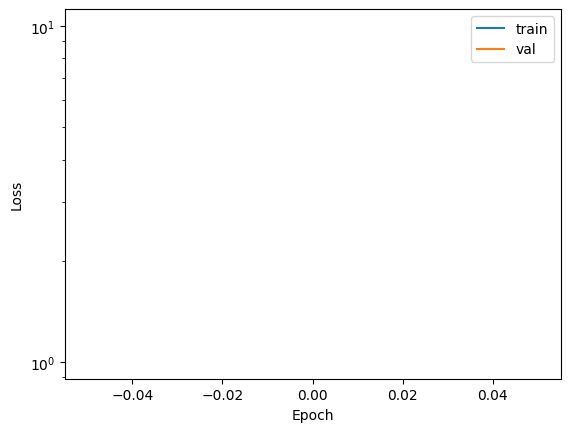

In [10]:
# Plot train and val losses as functions of epoch number
plt.figure()
plt.plot(errors["train"], label="train")
plt.plot(errors["val"], label="val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")